Percent of successful episode :  0.448 %


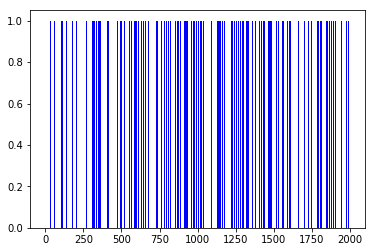

In [6]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# print np.identity(16)[0:1] # index 0
# print np.identity(16)[10:11] # index 10
# print np.identity(16)

env = gym.make('FrozenLake-v0') # stocastic world

# Input and output size based on the Env
input_size = env.observation_space.n
output_size = env.action_space.n
learning_rate = 0.1

# These lines establish the feed-forward part of the network used to choose actions
X = tf.placeholder(shape=[1, input_size], dtype=tf.float32) # state input
W = tf.Variable(tf.random_uniform([input_size, output_size], 0, 0.01)) # weight

Qpred = tf.matmul(X,W) # out Q prediction
Y = tf.placeholder(shape=[1, output_size], dtype=tf.float32) # Y label

loss = tf.reduce_sum(tf.square(Y - Qpred))
train = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

# set Q-learning related parameters
dis = .99
num_episodes = 2000

# Create lists to contain total rewards and steps per episode
rList = []
init = tf.global_variables_initializer()
def one_hot(x):
    return np.identity(16)[x:x+1]

with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        # Reset environment and get first new observation
        s = env.reset()
        e = 1. / ((i/50) + 10)
        rAll = 0
        done = False
        local_loss = []

        # Q-Network training
        while not done:
            # Choose an action by greedily (with a chance of random action) from the Q-network
            Qs = sess.run(Qpred, feed_dict={X: one_hot(s)})
            if np.random.rand(1) < e:
                a = env.action_space.sample()
            else:
                a = np.argmax(Qs)

            # Get new state and reward from environment
            s1, reward, done, _ = env.step(a)
            if done:
                # Update Q and no Qs + 1, since it's a terminal state
                Qs[0, a] = reward
            else:
                # Obtain the Q_s1 values by feeding the new state through our network
                Qs1 = sess.run(Qpred, feed_dict={X: one_hot(s1)})
                Qs[0, a] = reward + dis * np.max(Qs1)

            # Train our network using target (Y) and predicted Q(Qpred) values
            sess.run(train, feed_dict={X: one_hot(s), Y: Qs})

            rAll += reward
            s = s1

        rList.append(rAll)

print ("Percent of successful episode : ", str(sum(rList)/num_episodes), "%")
plt.bar(range(len(rList)), rList, color="blue")
plt.show()